## 能動的推論(AIF)とは


環境にて観測が潜在変数により生成される**生成プロセス**が存在し、そのプロセスを模倣した**生成モデル**をエージェントが内部に持つと仮定(例えばPOMDP)、エージェントはこの生成モデルをなるべく生成プロセスに近づけたいとする。AIFエージェントは得られた観測から生成モデルの潜在変数の分布を変分ベイズ推論(変分自由エネルギー(VFE)の最小化)により更新し生成モデルを生成プロセスに近づけ(**知覚**)、またポリシー(RLの方策とは異なり、行為系列のこと)を期待される将来の変分自由エネルギーが小さくなるように求め(負の**期待自由エネルギー(EFE)**からポリシーの分布を得る)、生成プロセスが生成モデルに近づくように**行動**する。またより遅い時間スケールで、生成モデル(尤度、遷移確率など)のパラメータのベイズ推論により生成モデルの構造自体を**学習**する。

RLと違い収益最大化が目的ではなく、エージェントの**選好**は(通常)観測の事前分布としてエンコードされており、ポリシーの推論時に用いられ行動に反映される。例えば選好の分布において低い確率を持つ観測(例えばペナルティ)が得られそうなポリシーに対しては、期待自由エネルギーにおけるサプライズの期待値の項が大きくなり、エージェントのポリシーとして選ばれる確率は小さくなる。また、しばしばポリシーの事前分布が定義され、エージェントのくせ・習慣を表現する。

ポリシーの分布は各(負の)期待自由エネルギーの逆温度つきsoftmax(ボルツマン分布)で得られるため、この逆温度(=**精度**)が大きいほど分布は急峻になり、エージェントがこの行動選択過程(期待自由エネルギーによる推論)に対して自信を持つことに対応する。尤度、遷移確率など他の分布で精度を扱うこともあり(対数スコアのボルツマン分布における逆温度など)、また精度の事前分布を考えることで生成モデル同様に精度を学習(推論)することができる。

AIFは人間の知覚・行動のモデルとして、計算論的精神医学、心理学、機械工学などさまざまな分野で注目されている。

詳しくは[Active Inference: The Free Energy Principle in Mind, Brain, and Behavior](https://www.amazon.co.jp/Active-Inference-Energy-Principle-Behavior/dp/0262045354)など。

今回は[pymdpライブラリ](https://github.com/infer-actively/pymdp/tree/master)を用いて、POMDPにおける能動的推論エージェントを実装する。

In [ ]:
### ライブラリのインポート
import os
import sys
import pathlib
import numpy as np
import copy

path = pathlib.Path(os.getcwd())
module_path = str(path.parent) + '/'
sys.path.append(module_path)

!pip install inferactively-pymdp 
import pymdp
from pymdp.agent import Agent
from pymdp.utils import plot_beliefs, plot_likelihood
from pymdp import utils
from pymdp.envs import TMazeEnvNullOutcome

## T-Mazeとは

[wikipedia](https://en.wikipedia.org/wiki/T-maze)

ここでは、左右の腕に報酬またはペナルティが、下に報酬の位置についての手がかり(L/R)があるシンプルな4マスのT迷路を考える。

## 実装

### a.生成プロセス・モデル定義

In [2]:
# 真の環境(生成プロセス)

reward_probabilities = [0.85, 0.15] #左右の腕の報酬確率 (あたり側は高確率でreward低確率でloss,ハズレ側は高確率でloss低確率でreward 腕以外の場所ではno reward)
env = TMazeEnvNullOutcome(reward_probs = reward_probabilities) #環境の設定
A_gp = env.get_likelihood_dist() #生成プロセスの尤度パラメータ　 このカテゴリ分布が生成プロセスの尤度p(y|x)
B_gp = env.get_transition_dist() #生成プロセスの遷移確率パラメータ　 このカテゴリ分布が生成プロセスの遷移確率p(x_(t+1)|x_t,π)



# 生成モデル
pA = utils.dirichlet_like(A_gp, scale = 1e16) # 生成モデルの尤度パラメータA_gmの、(ディリクレ)事前分布のパラメータ 基本的に、正しい(生成プロセスの)内容を間違いないと信じている(1e16)と仮定
pA[1][1:,1:3,:] = 1.0 # 左右の腕で報酬(あたり/ハズレ)を観測する確率についてのみ、自信がない(1.0)と仮定(学習対象)
A_gm = utils.norm_dist_obj_arr(pA) # 生成モデルの尤度パラメータ 　pAを正規化して(カテゴリ)尤度分布パラメータに変換
B_gm = copy.deepcopy(B_gp) # 生成モデルの遷移確率パラメータ　 ここでは完全に正しいと仮定



# エージェントの設定
controllable_indices = [0] # 潜在変数のうち、位置は制御可能
learnable_modalities = [1] # 観測のうち、報酬については学習可能



agent = Agent(A=A_gm,pA=pA,B=B_gm,
control_fac_idx=controllable_indices,
modalities_to_learn=learnable_modalities,
lr_pA = 0.25, # 学習率
use_param_info_gain=True) # エージェントは情報を得て不確実性を解消するためのモチベーション(好奇心)を持つ



# 選好 (このCを正規化したものが観測の(カテゴリ)事前分布のパラメータ)
agent.C[1][1] = 2.0 # 報酬モダリティにおいて、rewardへの選好
agent.C[1][2] = -2.0 # lossへの選好

#　他は一様



# 初期信念の設定(潜在変数の(カテゴリ)事前分布のパラメータ)
agent.D[0] = utils.onehot(0, agent.num_states[0]) # 初期位置はCENTERと(正しく)信じている

#　他は一様

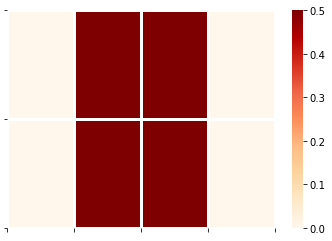

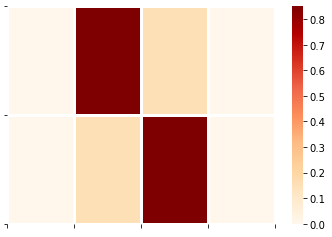

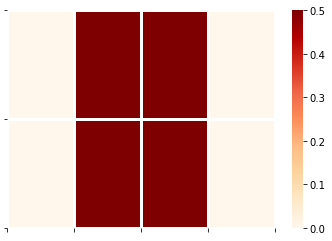

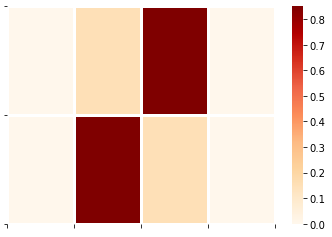

In [3]:
# Aのプロット(学習前)
plot_likelihood(agent.A[1][1:,:,0]) #生成モデルの報酬(reward,loss)に関する尤度(右があたりの時)
plot_likelihood(A_gp[1][1:,:,0]) #生成プロセスの報酬(reward,loss)に関する尤度(右があたりの時)
plot_likelihood(agent.A[1][1:,:,1]) #生成モデルの報酬(reward,loss)に関する尤度(左があたりの時)
plot_likelihood(A_gp[1][1:,:,1]) #生成プロセスの報酬(reward,loss)に関する尤度(左があたりの時)



### b.生成モデル学習

In [ ]:
T = 1000 # ステップ数
n = 100 # エピソード数

aif_episode_rewards = []

for i in range(n): # エピソード数分繰り返す

    agent.reset() # エージェントの信念(潜在変数)をリセット(学習したAはそのまま)
    obs = env.reset() # 環境を初期化(あたりが左か右かが決まる)、最初の観測を得る


    reward_conditions = ["Right Arm Better", "Left arm Better"] # どっちがあたりの環境か
    location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION'] # 位置の観測
    reward_observations = ['No reward','Reward!','Loss!'] # 報酬の観測
    cue_observations = ['Null','Cue Right','Cue Left'] #　手がかりの観測
    msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
    print(msg.format(reward_conditions[env.reward_condition], location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))



    episode_reward = 0


    pA_history = []

    all_actions = np.zeros((T, 2))
    
    for t in range(T):



        qx = agent.infer_states(obs) # 潜在変数の推論

        q_pi, efe = agent.infer_policies() # ポリシーの推論(MPCと類似) 各ポリシーの選択確率(とEFE)を返す デフォルトではポリシーの長さは1(ポリシー＝行動)

        action = agent.sample_action() # q_piから行動を選択 ポリシー長が2以上ならその最初の行動を選択

        pA_t = agent.update_A(obs) # 観測からpAをベイズ更新→Aを更新

        pA_history.append(pA_t)



        msg = """[Step {}] Action: [Move to {}]"""
        print(msg.format(t, location_observations[int(action[0])]))


        obs = env.step(action) # 行動の結果、次の観測を得る
        
        reward_obs = obs[1]
        if reward_obs == 1: reward = 1.0
        elif reward_obs == 2: reward = -1.0
        else: reward = 0.0
            
        episode_reward += reward

        all_actions[t, :] = action


        msg = """[Step {}] Observation: [{}, {}, {}]"""
        print(msg.format(t, location_observations[int(obs[0])], reward_observations[int(obs[1])], cue_observations[int(obs[2])]))
    
    aif_episode_rewards.append(episode_reward)


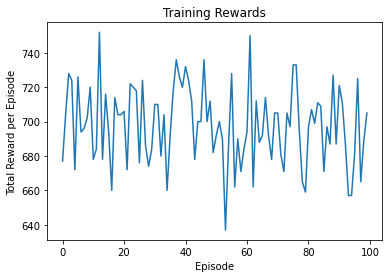

In [5]:
import matplotlib.pyplot as plt

plt.plot(aif_episode_rewards)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward per Episode')
plt.show()

### c.推論

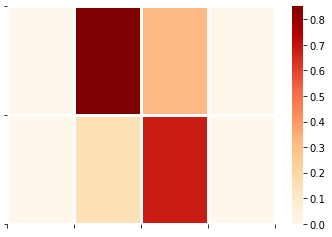

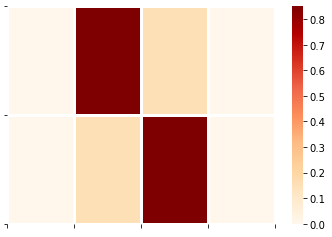

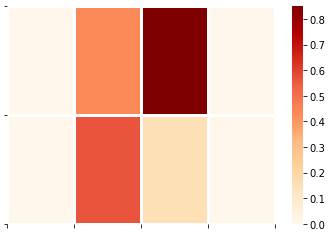

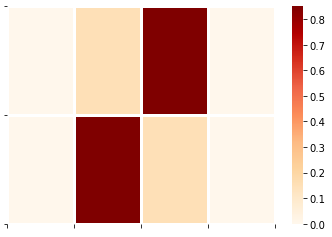

In [6]:

# Aのプロット(学習後)
plot_likelihood(agent.A[1][1:,:,0]) #生成モデルの報酬(reward,loss)に関する尤度(右があたりの時)
plot_likelihood(A_gp[1][1:,:,0]) #生成プロセスの報酬(reward,loss)に関する尤度(右があたりの時)
plot_likelihood(agent.A[1][1:,:,1]) #生成モデルの報酬(reward,loss)に関する尤度(左があたりの時)
plot_likelihood(A_gp[1][1:,:,1]) #生成プロセスの報酬(reward,loss)に関する尤度(左があたりの時)



In [7]:
T = 10 # ステップ数

agent.use_param_info_gain = False #好奇心(探索)をオフ


agent.reset() # エージェントの信念をリセット(学習したAはそのまま)
obs = env.reset() # 環境を初期化(あたりが左か右かが決まる)、最初の観測を得る


reward_conditions = ["Right Arm Better", "Left arm Better"] # どっちがあたりの環境か
location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION'] # 位置の観測
reward_observations = ['No reward','Reward!','Loss!'] # 報酬の観測
cue_observations = ['Null','Cue Right','Cue Left'] #　手がかりの観測
msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
print(msg.format(reward_conditions[env.reward_condition], location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))


all_actions = np.zeros((T, 2))

for t in range(T):

    qx = agent.infer_states(obs) # 潜在変数の推論

    q_pi, efe = agent.infer_policies() # ポリシーの推論(MPCと類似) 各ポリシーの選択確率(とEFE)を返す デフォルトではポリシーの長さは1(ポリシー＝行動)

    action = agent.sample_action() # q_piから行動を選択 ポリシー長が2以上ならその最初の行動を選択


    msg = """[Step {}] Action: [Move to {}]"""
    print(msg.format(t, location_observations[int(action[0])]))

    obs = env.step(action) # 行動の結果、次の観測を得る

    all_actions[t,:] = action

    msg = """[Step {}] Observation: [{}, {}, {}]"""
    print(msg.format(t, location_observations[int(obs[0])], reward_observations[int(obs[1])], cue_observations[int(obs[2])]))

 === Starting experiment === 
 Reward condition: Left arm Better, Observation: [CENTER, No reward, Null]
[Step 0] Action: [Move to CUE LOCATION]
[Step 0] Observation: [CUE LOCATION, No reward, Cue Left]
[Step 1] Action: [Move to LEFT ARM]
[Step 1] Observation: [LEFT ARM, Reward!, Null]
[Step 2] Action: [Move to LEFT ARM]
[Step 2] Observation: [LEFT ARM, Reward!, Null]
[Step 3] Action: [Move to LEFT ARM]
[Step 3] Observation: [LEFT ARM, Reward!, Null]
[Step 4] Action: [Move to LEFT ARM]
[Step 4] Observation: [LEFT ARM, Reward!, Null]
[Step 5] Action: [Move to LEFT ARM]
[Step 5] Observation: [LEFT ARM, Loss!, Null]
[Step 6] Action: [Move to LEFT ARM]
[Step 6] Observation: [LEFT ARM, Reward!, Null]
[Step 7] Action: [Move to LEFT ARM]
[Step 7] Observation: [LEFT ARM, Reward!, Null]
[Step 8] Action: [Move to LEFT ARM]
[Step 8] Observation: [LEFT ARM, Reward!, Null]
[Step 9] Action: [Move to LEFT ARM]
[Step 9] Observation: [LEFT ARM, Reward!, Null]


### d.RL(Q学習)の実装と比較

ここでは単純なQ学習アルゴリズムを同様の環境で実装した。(POMDPに適した実装でないため当然だが、)環境の変化(右/左があたり)を捉えられずうまく学習できない。

In [8]:
class QLearningAgent:

    def __init__(self, num_states, num_actions, gamma=0.99, alpha=0.1):
        self.num_actions = num_actions
        self.gamma = gamma      # 割引率
        self.alpha = alpha      # 学習率
        self.qtable = np.zeros((num_states, num_actions))

    def update_q_table(self, state, action, reward, next_state):
        self.qtable[state, action] = (1 - self.alpha) *  self.qtable[state, action] + self.alpha* (reward + self.gamma * self.qtable[next_state].max())

    def get_greedy_action(self, state):
        return np.argmax(self.qtable[state])

    def get_action(self, state, episode):
        epsilon = 0.7 * (1/(episode+1))  # ここでは0.5から減衰していくようなεを設定
        if epsilon <= np.random.uniform(0,1):
            action = self.get_greedy_action(state)
        else:
            action = np.random.choice(self.num_actions)
        return action

NUM_LOCATIONS = env.num_states[0]
NUM_ACTIONS = env.num_controls[0]
agent_ql = QLearningAgent(num_states=NUM_LOCATIONS, num_actions=NUM_ACTIONS)


In [ ]:
T = 1000 # ステップ数
n = 100 # エピソード数


reward_conditions = ["Right Arm Better", "Left arm Better"] # どっちがあたりの環境か
location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION'] # 位置の観測
reward_observations = ['No reward','Reward!','Loss!'] # 報酬の観測
cue_observations = ['Null','Cue Right','Cue Left'] #　手がかりの観測

ql_episode_rewards = []

for episode in range(n):
    obs = env.reset()
    state = obs[0]
    episode_reward = 0
    msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
    print(msg.format(reward_conditions[env.reward_condition], location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))


    
    for t in range(T):
        action = agent_ql.get_action(state, episode)
        
        msg = """[Step {}] Action: [Move to {}]"""
        print(msg.format(t, location_observations[int(action)]))

        obs = env.step([action,0])
        
        msg = """[Step {}] Observation: [{}, {}, {}]"""
        print(msg.format(t, location_observations[int(obs[0])], reward_observations[int(obs[1])], cue_observations[int(obs[2])]))
        
        # 観測から報酬を自作
        reward_obs = obs[1]
        if reward_obs == 1: reward = 1.0
        elif reward_obs == 2: reward = -1.0
        else: reward = 0.0
            
        episode_reward += reward
        next_state = obs[0]
        agent_ql.update_q_table(state, action, reward, next_state)
        state = next_state
    
    ql_episode_rewards.append(episode_reward)


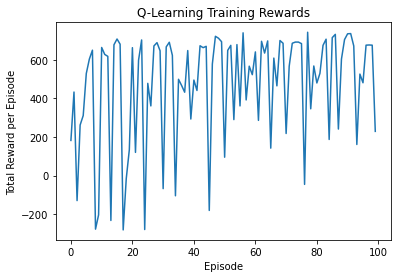

In [10]:
import matplotlib.pyplot as plt

plt.plot(ql_episode_rewards)
plt.title('Q-Learning Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward per Episode')
plt.show()

In [11]:
T = 10 # ステップ数


ql_episode_rewards = []


obs = env.reset()
state = obs[0]
episode_reward = 0

reward_conditions = ["Right Arm Better", "Left arm Better"] # どっちがあたりの環境か
location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION'] # 位置の観測
reward_observations = ['No reward','Reward!','Loss!'] # 報酬の観測
cue_observations = ['Null','Cue Right','Cue Left'] #　手がかりの観測
msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
print(msg.format(reward_conditions[env.reward_condition], location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))


    
for t in range(T):
        action = agent_ql.get_greedy_action(state)
        
        msg = """[Step {}] Action: [Move to {}]"""
        print(msg.format(t, location_observations[int(action)]))

        obs = env.step([action,0])
        msg = """[Step {}] Observation: [{}, {}, {}]"""
        print(msg.format(t, location_observations[int(obs[0])], reward_observations[int(obs[1])], cue_observations[int(obs[2])]))
        
        # 観測から報酬を自作
        reward_obs = obs[1]
        if reward_obs == 1: reward = 1.0
        elif reward_obs == 2: reward = -1.0
        else: reward = 0.0
            
        episode_reward += reward
        next_state = obs[0]

        state = next_state

 === Starting experiment === 
 Reward condition: Right Arm Better, Observation: [CENTER, No reward, Null]
[Step 0] Action: [Move to RIGHT ARM]
[Step 0] Observation: [RIGHT ARM, Reward!, Null]
[Step 1] Action: [Move to LEFT ARM]
[Step 1] Observation: [LEFT ARM, Loss!, Null]
[Step 2] Action: [Move to LEFT ARM]
[Step 2] Observation: [LEFT ARM, Reward!, Null]
[Step 3] Action: [Move to LEFT ARM]
[Step 3] Observation: [LEFT ARM, Loss!, Null]
[Step 4] Action: [Move to LEFT ARM]
[Step 4] Observation: [LEFT ARM, Loss!, Null]
[Step 5] Action: [Move to LEFT ARM]
[Step 5] Observation: [LEFT ARM, Loss!, Null]
[Step 6] Action: [Move to LEFT ARM]
[Step 6] Observation: [LEFT ARM, Loss!, Null]
[Step 7] Action: [Move to LEFT ARM]
[Step 7] Observation: [LEFT ARM, Loss!, Null]
[Step 8] Action: [Move to LEFT ARM]
[Step 8] Observation: [LEFT ARM, Loss!, Null]
[Step 9] Action: [Move to LEFT ARM]
[Step 9] Observation: [LEFT ARM, Loss!, Null]


## 論文調査

### AIFとCaIの関係

(参考:[On the Relationship of Active Inference and Control as Inference](https://link.springer.com/chapter/10.1007/978-3-030-64919-7_1))

AIFとCaIはいずれも変分推論により逐次的意思決定を行う枠組みであり、以下のような共通点・違いが見られる(以下、選好が報酬に比例するものとしている)。

- 離散時間において、いずれもMDP/POMDPによる定式化が可能である。ただしCaIでは最適性変数を導入しMDP/POMDPを拡張することによって価値を扱うのに対し、AIFは生成モデルに直接価値をエンコードする。すなわち、CaIエージェントは客観的な世界の表現を回復しその中で目標を追求するのに対し、AIFエージェントは選好に偏った世界の表現をもち、それが現実と一致することを望む。

- 特にCaIは(最適性変数=1のもとでの)方策を、AIFは(期待自由エネルギーが小さくなる)行動系列を推論するが、お互いに他方の形式(方策↔︎行動系列)での解釈が可能である。

- 選好を観測の事前分布でなく、潜在変数のもとでの観測の尤度にエンコードする(好ましい隠れ状態が存在しそこから好ましい観測が得られるとする)**尤度AIF**を考えると、POMDPの尤度AIFはMDPのCaIと等価となる(尤度AIFにおいて観測は最適性変数のように機能し、観測と価値が統合され自由度がひとつ減る)。なおMDPのAIFはKL制御と等価である。

- 一般的にAIFは期待情報利得を扱うため目標志向の探索が自然に行われるが、CaIはエントロピー最大化に基づく探索を行い、内発的価値(好奇心)を自然には持たない。

### 深層AIFについて

基本的なAIFでは(RLと同じように)低次元かつ離散的な空間でしか扱えないなどの問題がある。画像入力や連続空間での応用のため、深層学習を用いた枠組みが複数提案されている。以下二例を簡単に紹介する。

- [Deep Active Inference as Variational Policy Gradients](https://www.sciencedirect.com/science/article/abs/pii/S0022249620300298)

主要な確率分布(尤度、遷移確率、(近似)ポリシー、EFE)をDNNで近似しVFE勾配(EFEは二乗誤差勾配)でそれぞれ学習することで、OpenAIGym環境でもDQN,Actor-Criticに劣らない(ときに凌ぐ)性能を見せた。

この深層AIFとActor-Criticのような方策勾配更新アルゴリズムを比較すると、深層AIFには方策エントロピー項が追加されている(Control as InferenceからMaxEnt-RLが導かれることからも推察できる)。実際、方策勾配法にエントロピー項を追加し性能が改善することは理論的、経験的に示されている。

- [Contrastive Active Inference](https://proceedings.neurips.cc/paper/2021/hash/73c730319cf839f143bf40954448ce39-Abstract.html)


強化学習における報酬は通常人間による設計が必要であり、恣意性や欠陥などのリスクがある。一方でAIFは制御目標を自己教師あり学習にて自然に符号化できる可能性があるが、(結局報酬を与えるなど)これはしばしば軽視されている。また、画像入力などの高次元環境において観測の再構成を要する(VAE的な)構成は、AIFの拡張を妨げていると考えられる。

尤度ベースのVFE,EFEをそれぞれ対照手法が適用できるよう変換し、DNNを用いて構成された対照能動的推論は、(深層)尤度AIFよりも著しく性能・コストを改善し、(報酬にアクセスしないにも関わらず)Dreamerともほぼ同等の性能を見せた。


## 最後に

今回のプロジェクトでは、理解のしやすさや基本的なAIFを複雑な環境に適用する難しさから、極めて単純な環境におけるAIFの実装を通じて、AIFという枠組みがどのようにして環境と相互作用し学習・推論するのかについて理解を深めた。昨今は深層学習の利用によりロボット実装など複雑な環境で適用可能なAIFも複数提案されている。今後の調査課題としたい。

また当初から興味のあったAIFとCaIの関係について、両者の枠組みはある条件で数学的に一致することが示されているとわかった。そのため今後は、CaIから導かれるSAC,SLACなどとの厳密な対応について実装を通して理解したいと考えている。

CaIを介しモデルフリーRLとの関係が示唆されているにも関わらず、AIFは推論によって生成モデルを更新しながらモデルに基づき考えられる行動系列に対してMPCのようなシミュレーションと選択を行うという点で、モデルベースRL(世界モデル)と近しい枠組みであるとも考えられる。モデルベースRLとの関係性についても今後調査したい。